<a href="https://colab.research.google.com/github/techwithanirudh/Shared/blob/master/Copy_of_Toonify_yourself_Flask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://826990c43bf5.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
face.png
<class 'bytes'>
Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "face_01.png"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


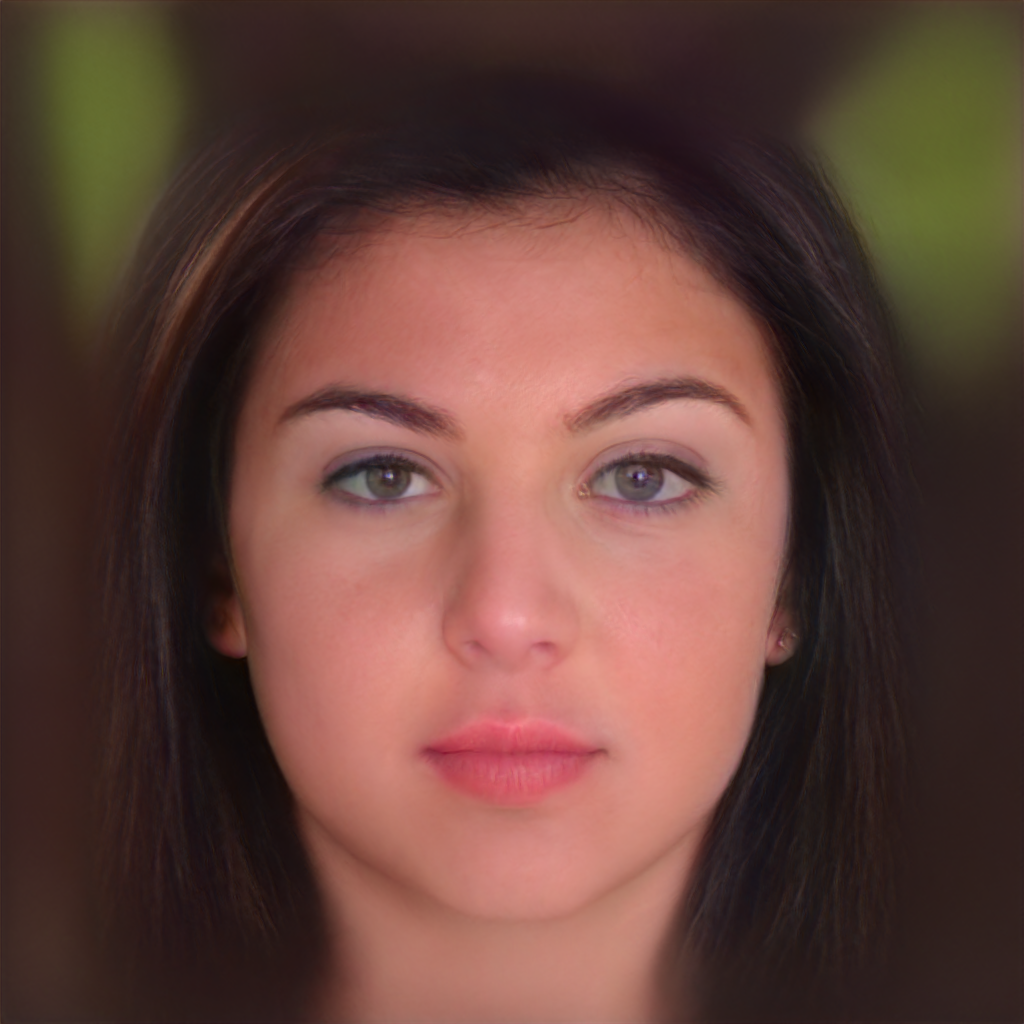

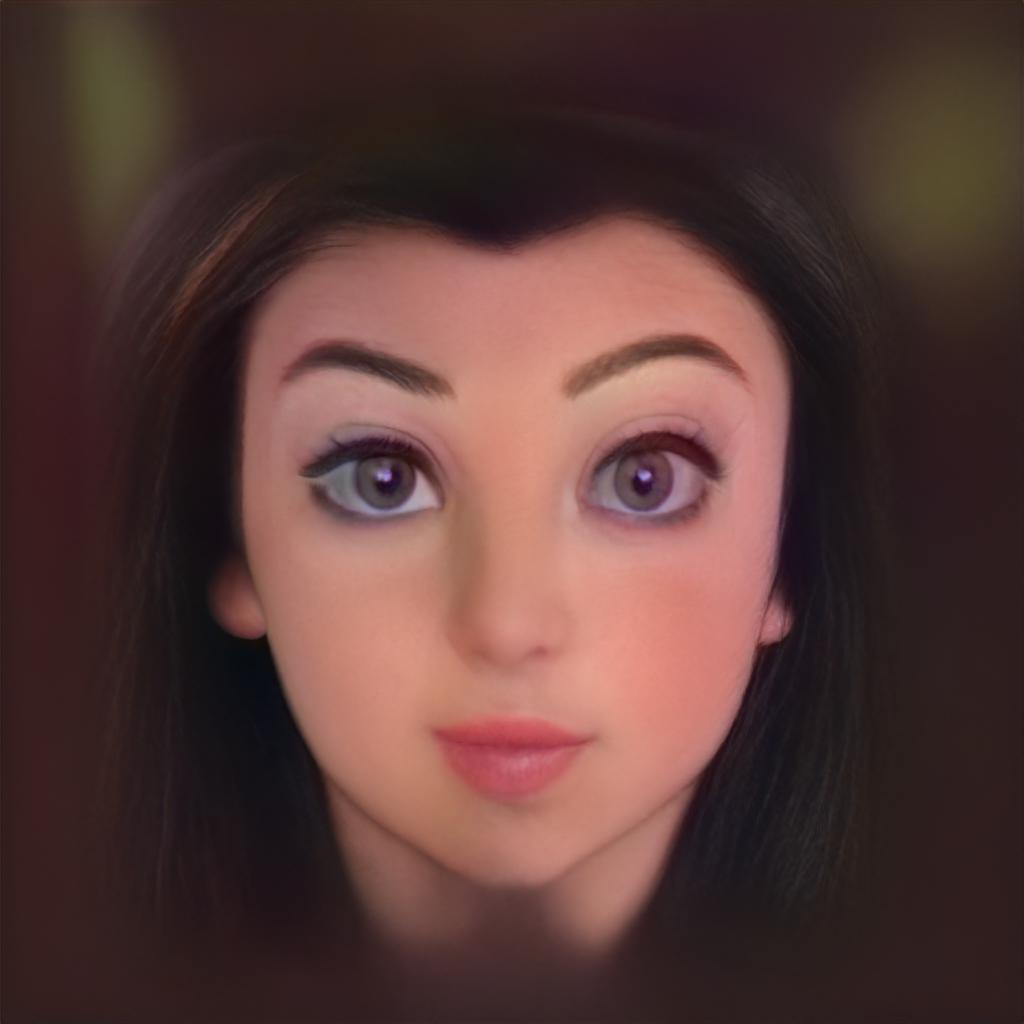

127.0.0.1 - - [30/Dec/2020 13:56:47] "POST /path/face.png/compute HTTP/1.1" 200 -


In [22]:
# !wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg
# from google.colab import files
# import os

# os.chdir('/content/stylegan2/raw')

# uploaded = files.upload()
# for filename in uploaded.keys():
#   print('User uploaded file "{name}" with {length} bytes'.format(name=filename, length=len(uploaded[filename])))

# os.chdir('/content/stylegan2')

# main_helper.py -->
# import pretrained_networks
# import numpy as np
# from PIL import Image
# import dnnlib
# import dnnlib.tflib as tflib
# from pathlib import Path
# from IPython import get_ipython

# # use my copy of the blended model to save Doron's download bandwidth
# # get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
# blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
# ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

# _, _, Gs_blended = pretrained_networks.load_networks(blended_url)
# print(Gs_blended)
# _, _, Gs = pretrained_networks.load_networks(ffhq_url)  

# latent_dir = Path("generated")
# latents = latent_dir.glob("*.npy")
# for latent_file in latents:
#   latent = np.load(latent_file)
#   latent = np.expand_dims(latent,axis=0)
#   synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
#   print(Gs_blended)
#   images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
#   Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))
# <--

# template/index.html -->
# <!DOCTYPE html>
# <html>
# <head>
#     <title>Index</title>
# </head>
# <body>
#     <img src="{{ image }}" alt="Image">
# </body>
# </html>
# <--

# %tensorflow_version 1.x
# !git clone https://github.com/justinpinkney/stylegan2
# %cd stylegan2
# !nvcc test_nvcc.cu -o test_nvcc -run
# !mkdir raw
# !mkdir aligned
# !mkdir generated

!pip install flask-ngrok
from flask import Flask, render_template, request
import os
from flask_ngrok import run_with_ngrok
import base64
from werkzeug.utils import secure_filename

GENERATED_FOLDER = '/content/stylegan2/generated'
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = GENERATED_FOLDER
run_with_ngrok(app)

@app.route('/path/<filenm>/compute', methods=['POST'])
def getFile(filenm):
  global filename
  filename = secure_filename(filenm)
  print(filename)
  imgdata = request.get_data()
  print(type(imgdata))
  imgdata = base64.b64decode(imgdata)
  with open(f'/content/stylegan2/raw/{filename}', 'wb') as f:
    f.write(imgdata)
  base64data = compute()
  return base64data


def mainHelp():
  get_ipython().system('python align_images.py raw aligned')
  get_ipython().system('python project_images.py --num-steps 500 aligned generated')
  get_ipython().system('python main_helper.py')

def compute():
  os.chdir('/content/stylegan2')
  import pretrained_networks
  import numpy as np
  from PIL import Image
  import dnnlib
  import dnnlib.tflib as tflib
  from pathlib import Path
  mainHelp()
  from IPython.display import Image 
  filenameO = filename.split('.')[0]
  embedded = Image(filename=f"generated/{filenameO}_01.png", width=256)
  display(embedded)
  tooned = Image(filename=f"generated/{filenameO}_01-toon.jpg", width=256)
  display(tooned)
  
  os.remove(f'generated/{filenameO}_01.png')
  os.remove(f'generated/{filenameO}_01.npy')
  os.remove(f'aligned/{filenameO}_01.png')
  os.remove(f'raw/{filename}')
  with open(f'generated/{filenameO}_01-toon.jpg', 'rb') as img_file:
    my_string = base64.b64encode(img_file.read())
  os.remove(f'generated/{filenameO}_01-toon.jpg')
  return my_string

if __name__ == '__main__':
    app.run()

In [ ]:
import os
print(os.environ)

environ({'NO_GCE_CHECK': 'True', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', '__EGL_VENDOR_LIBRARY_DIRS': '/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/', 'CUDA_VERSION': '10.1.243', 'PATH': '/tensorflow-1.15.2/python3.6/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/lib64-nvidia', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '0', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.7.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20201217', 'JPY_PARENT_PID': '62', 'PYTHONPATH': '/tensorflow-1.15.2/python3.6:/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterA

In [ ]:
import os 
os.chdir('/content/stylegan2')

import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

In [ ]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


AttributeError: ignored